<a href="https://colab.research.google.com/github/All4Nothing/pytorch-DL-project/blob/main/Ch03_Deep_CNN_Architecture(6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. 심층 CNN 아키텍처

## DenseNet 아키텍처

ResNet은 역전파하는 동안 경사를 보존하기 위해 (입력과 출력을 바로 연결함으로써) 항등 함수를 사용한다.  
그렇지만 극단적으로 깊은 네트워크의 경우 이 원칙만으로 출력 계층에서 입력 계층에 도달할 때까지 경사를 큰 값으로 유지하기 충분치 않을 수 있다.  
DenseNet은 경사가 소실되지 않고 흐를 수 있을 뿐 아니라 필요한 매개변수 개수를 더 줄이도록 설계됐다.

ResNet에서 스킵 연결은 **Residual Block**의 입력을 출력에 바로 연결한다. 하지만 residual block 간에는 순차적으로 연결된다. 즉, residual block3은 residual block2와 직접 연결되지만 residual block1 과는 바로 연결되지 않는다.

* Residual Block : 한 layer의 결과값을 바로 다음 layer에만 넣어주는 것이 아니라 좀 더 뒤에 있는 layer에도 넣어주는 것  
![Residual Block](https://velog.velcdn.com/images/1-june/post/39713537-cb2c-45bb-835d-a35229001b06/image.png)

DenseNet 또는 밀집 네트워크에서는 **Dense Block(밀집 블록)** 내의 모든 합성곱 계층이 서로 연결된다. 게다가 모든 Dense Block은 DenseNet 전체 안에서 다른 밀집 블록과 모두 연결된다. Dense Block은 3x3으로 밀집 연결된 합성곱 계층 두 개로 구성된 모듈이다.  
이렇게 밀집 연결하면 모든 계층은 네트워크에서 자기보다 앞선 계층 전체로부터 정보를 받는다. 이로써 마지막 계층에서 제일 처음에 위치한 계층까지 Gradient(경사)값을 크게 유지하며 흐를 수 있다. 놀랍게도 이런 네트워크 설정의 매개변수 개수도 작다. 모든 계층이 이전에 위치한 모든 계층에서 Feature Map(특징 맵)을 받으므로 필요한 채널 수(깊이)가 작아질 수 있다. 이전 모델에서는 깊이가 깊어진다는 것은 이전 계층에서 축적된 정보를 나타냈지만, 밀집 연결 덕분에 네트워크의 모든 곳에서 이렇게 축적된 정보는 더 이상 필요하지 않게 됐다.  

* Feature Map : input으로부터 kernel을 사용하여 convolution(합성곱) 연산을 통해 나온 결과. Feature Map의 목적은 각각의 특징들을 패턴으로 읽어내는 것. 말 그대로 특징을 잡아내는 맵.  
![Feature Map](https://velog.velcdn.com/images%2Fjee-9%2Fpost%2Fb229fc16-d83b-4b0c-ba1d-07d7e39c2e87%2Fimage.png)

ResNet과 DenseNet의 주요 차이점 중 하나는 ResNet에서는 스킵 연결을 사용해 입력을 출력에 더했다는 것이다. 그렇지만 DenseNet의 경우 이전 계층의 출력은 현재 계층의 출력과 결합된다. 그리고 이 결합은 깊이의 차원에서 이뤄진다.  
이것은 네트워크를 따라가면서 출력의 크기가 폭발적으로 증가하게 된다는 문제를 야기한다. 이런 복합적인 효과를 방지하기 위해 이 네트워크를 위한 **Transition Block(전환 블록)**이라는 특수한 유형의 블록이 고안됐다.  
1x1 합성곱 계층과 2x2 풀링 계층으로 구성된 이 블록은 깊이 차원의 크기를 표준화 또는 재설정하여 이 블록의 출력이 이어 나오는 밀집 블록에 제공될 수 있게 한다.

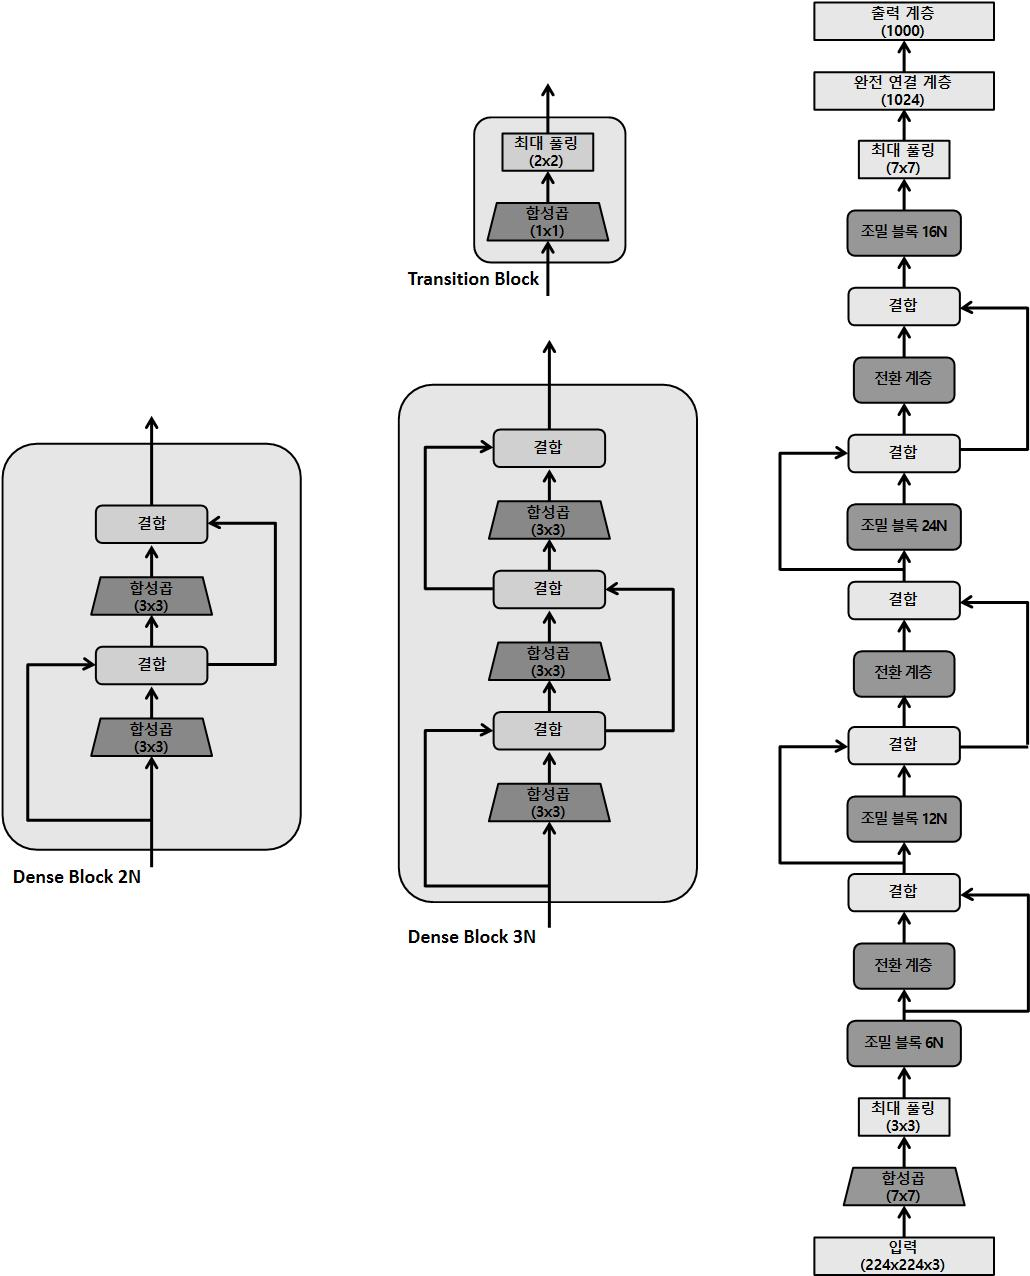

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class DenseBlock(nn.Module):
    def __init__(self, input_num_planes, rate_inc):
        super(DenseBlock, self).__init__()
        self.batch_norm1 = nn.BatchNorm2d(input_num_planes)
        self.conv_layer1 = nn.Conv2d(
            in_channels=input_num_planes,
            out_channels=4 * rate_inc,
            kernel_size=1,
            bias=False
        )
        self.batch_norm2 = nn.BatchNorm2d(4 * rate_inc)
        self.conv_layer2 = nn.Conv2d(
            in_channels=4*rate_inc,
            out_channels=rate_inc,
            kernel_size=3,
            padding=1,
            bias=False
        )

    def forward(self, inp):
        op = self.conv_layer1(F.relu(self.batch_norm1(inp)))
        op = self.conv_layer2(F.relu(self.batch_norm2(op)))
        op = torch.cat([op,inp], 1)
        return op

class TransBlock(nn.Module):
    def __init__(self, input_num_planes, output_num_planes):
        super(TransBlock, self).__init__()
        self.batch_norm = nn.BatchNorm2d(input_num_planes)
        self.conv_layer = nn.Conv2d(
            in_channels=input_num_planes,
            out_channels=output_num_planes,
            kernel_size=1,
            bias=False
        )
    def forward(self, inp):
        op = self.conv_layer(F.relu(self.batch_norm(inp)))
        op = F.avg_pool2d(op, 2)
        return op

In [4]:
import torchvision.models as models
densenet121 = models.densenet121(pretrained=True)
densenet161 = models.densenet161(pretrained=True)
densenet169 = models.densenet169(pretrained=True)
densenet201 = models.densenet201(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 61.5MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may

ResNet처럼 단순한 구조를 갖는 기본 building block의 장점과 Inception 모듈의 split-transformation-merge 구조의 장점을 적용하여 **Inception-ResNe**t과 **ResNeXt**과 같은 모델이 만들어졌다.  
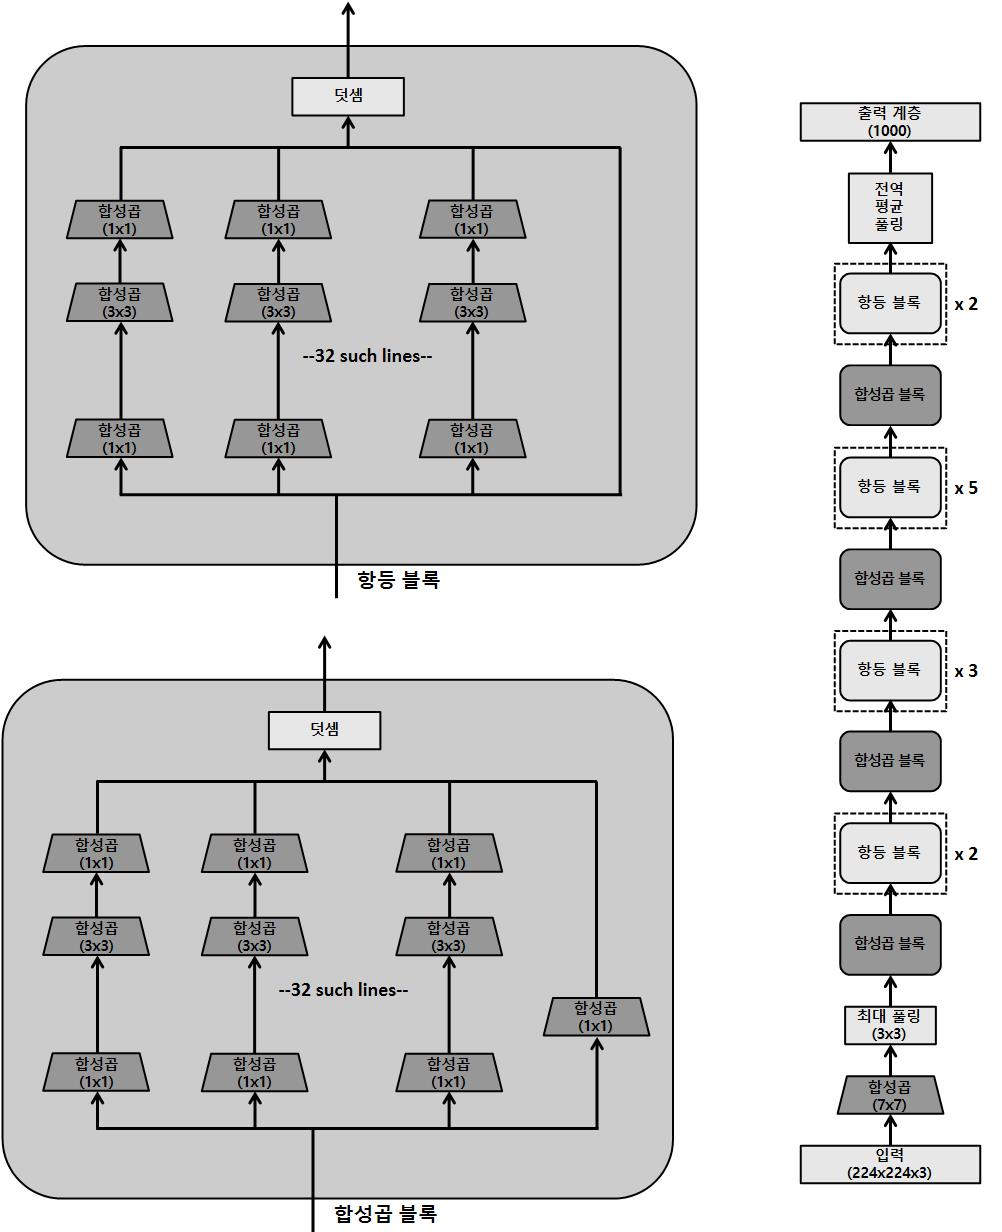  
*ResNeXt 아키텍처*

ResNeXt는 광범위하게 보면 ResNet과 Inception 하이브리드의 변형처럼 보인다. Residual Block에 parallel convolutional branch(병렬 합성곱 분기)가 많고 parallelism(병렬 처리)는 Inception 네트워크에서 파생되기 때문이다.